## Weight quantization using IBM aihwkit - PyTorch
---

In the following notebook, we will demonstrate how to quantize the weights of a given neural network using the IBM aihwkit library. We will use a model inspired by the ResNet9 architecture and the CIFAR-10 dataset. 
For simplicity, to implement the analog version of the model to be used by the simulator, we will use the auxiliary functions defined in the examples [18_cifar10_on_resnet.ipynb](../examples/18_cifar10_on_resnet.py), [30_external_hardware_aware_model.ipynb](../examples/30_external_hardware_aware_model.py) and the tutorial [hw_aware_training.ipynb](../notebooks/tutorial/hw_aware_training.ipynb)  form which this notebook takes ample inspiration. We will also show how to quantize the weights of a model converted from digital to analog using the [built-in functions](../src/aihwkit/nn/conversion.py) provided by the aihwkit library.


We consider a simple analog device composed of ***single device crossbars tiles*** and a ***weight quantization at int3***. For simplicity, consider the simulation to be carried out on the CPU

In [1]:
# !wget https://aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud/aihwkit-0.9.0+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
# !pip install aihwkit-0.9.0+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
# !pip install torchmetrics

In [2]:
import os
import torch
from torch import nn, Tensor, device, no_grad, manual_seed
from torch import nn
from torchvision.datasets.utils import download_url
import torch.nn.functional as F
from torchmetrics.functional import accuracy
import torchvision
from torch.nn.functional import mse_loss

# Import functions defined in a specific path
import sys
sys.path.append('../src/')


from aihwkit.simulator.configs import ConstantStepDevice, SingleRPUConfig, FloatingPointDevice
from aihwkit.optim import AnalogSGD
from aihwkit.inference.noise.base import BaseNoiseModel
from aihwkit.inference.noise.pcm import PCMLikeNoiseModel
from aihwkit.inference.compensation.drift import GlobalDriftCompensation
from aihwkit.inference.compensation.base import BaseDriftCompensation
from aihwkit.simulator.configs import InferenceRPUConfig, TorchInferenceRPUConfig
from aihwkit.simulator.presets.utils import PresetIOParameters
from aihwkit.simulator.parameters import (
    MappingParameter,
    IOParameters,
    PrePostProcessingParameter,
    InputRangeParameter,
    WeightClipParameter,
    WeightRemapParameter,
    WeightModifierParameter,
    WeightQuantizerParameter,
)
from aihwkit.simulator.parameters.enums import (
    WeightClipType,
    BoundManagementType,
    NoiseManagementType,
    WeightNoiseType,
    WeightRemapType,
    WeightModifierType,
)
from aihwkit.nn import AnalogLinearMapped, AnalogConv2dMapped, AnalogSequential, AnalogLinear
# from aihwkit.utils.visualization import plot_device_compact
# from aihwkit.utils.analog_info import analog_summary
# from aihwkit.utils.fitting import fit_measurements
from aihwkit.nn.conversion import convert_to_analog
from aihwkit.utils.analog_info import analog_summary
from aihwkit.inference.calibration import (
    calibrate_input_ranges,
    InputRangeCalibrationType,
)
#from aihwkit.simulator.rpu_base import cuda

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dataclasses import dataclass, field
from typing import Optional

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [3]:

# Define the quantization levels
quantization_levels = 4
assert quantization_levels & (quantization_levels - 1) == 0, "quantization_levels must be a power of 2"

class LambdaLayer(torch.nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

# Definitions of some building blocks for the ResNet, taken form example '18_cifar10_on_resnet.ipynb'
class BasicBlock(torch.nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option="A"):
        super(BasicBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = torch.nn.BatchNorm2d(planes)

        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == "A":
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(
                    lambda x: F.pad(
                        x[:, :, ::2, ::2],
                        (0, 0, 0, 0, planes // 4, planes // 4),
                        "constant",
                        0,
                    )
                )
            elif option == "B":
                self.shortcut = torch.nn.Sequential(
                    torch.nn.Conv2d(
                        in_planes,
                        self.expansion * planes,
                        kernel_size=1,
                        stride=stride,
                        bias=False,
                    ),
                    torch.nn.BatchNorm2d(self.expansion * planes),
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Resnet9(torch.nn.Module):
    """
    From https://github.com/matthias-wright/cifar10-resnet/
    """

    def __init__(self, channels):
        super(Resnet9, self).__init__()

        self.channels = channels

        # resnet9 [56,112,224,224]
        # resnet9s [28,28,28,56]

        self.bn1 = torch.nn.BatchNorm2d(num_features=channels[0], momentum=0.9)
        self.bn2 = torch.nn.BatchNorm2d(num_features=channels[1], momentum=0.9)
        self.bn3 = torch.nn.BatchNorm2d(num_features=channels[2], momentum=0.9)
        self.bn4 = torch.nn.BatchNorm2d(num_features=channels[3], momentum=0.9)

        self.conv = torch.nn.Sequential(
            # prep
            torch.nn.Conv2d(
                in_channels=3,
                out_channels=channels[0],
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            self.bn1,
            torch.nn.ReLU(inplace=True),
            # Layer 1
            torch.nn.Conv2d(
                in_channels=channels[0],
                out_channels=channels[1],
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            self.bn2,
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            BasicBlock(in_planes=channels[1], planes=channels[1], stride=1),
            # Layer 2
            torch.nn.Conv2d(
                in_channels=channels[1],
                out_channels=channels[2],
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            self.bn3,
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            # Layer 3
            torch.nn.Conv2d(
                in_channels=channels[2],
                out_channels=channels[3],
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            self.bn4,
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            BasicBlock(in_planes=channels[3], planes=channels[3], stride=1),
            torch.nn.MaxPool2d(kernel_size=4, stride=4),
        )

        self.fc = torch.nn.Linear(in_features=channels[3], out_features=10, bias=True)

    def forward(self, x):
        out = self.conv(x)
        out = out.view(-1, self.channels[3])
        out = self.fc(out)
        return out

def resnet9s():
    return Resnet9(channels=[28, 28, 28, 56])

def createOuterBlock(InnerBlock, in_ch, hidden_ch ,n_internal_blocks, initial_stride):
    strides = [initial_stride] + [1] * (n_internal_blocks - 1)
    layers = []
    for stride in strides:
        layers.append(InnerBlock(in_ch, hidden_ch, stride=stride))
        in_ch = hidden_ch
    return AnalogSequential(*layers)

def createResNet34(basic_block, list_num_blocks, out_classes=10):
    in_ch = 16
    conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
    bn1 = nn.BatchNorm2d(16)
    layer1 = createOuterBlock(basic_block, in_ch, 16, list_num_blocks[0], initial_stride=1)
    layer2 = createOuterBlock(basic_block, in_ch, 32, list_num_blocks[1], initial_stride=2)
    layer3 = createOuterBlock(basic_block, in_ch, 64, list_num_blocks[2], initial_stride=2)
    fc = AnalogLinearMapped(64, out_classes)

    return AnalogSequential(conv1, bn1, layer1, layer2, layer3, nn.AdaptiveAvgPool2d(1), nn.Flatten(), fc)


def get_test_loader(batch_size=128):
    transform_test = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
            ),
        ]
    )
    testset = torchvision.datasets.CIFAR10(
        root="data/cifar10", train=False, download=True, transform=transform_test
    )
    test_loader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )
    return test_loader


def evaluate_model(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        return 100.0 * correct / total
    

class Sampler:
    """Example of a sampler used for calibration."""

    def __init__(self, loader, device):
        self.device = device
        self.loader = iter(loader)
        self.idx = 0

    def __iter__(self):
        return self

    def __next__(self):
        x, _ = next(self.loader)
        self.idx += 1
        if self.idx > 100:
            raise StopIteration

        return ([x.to(self.device)], {})



In this section, analogously to the 'hw_aware_training.ipynb' tutorial, we will set the RPU configuration. To do so, we define a new class whose features are mainly taken form [StandardHWATrainingPreset](../src/aihwkit/simulator/presets/inference.py)
1. We set the ***mapping*** parameters, responsible for the mapping of the weights to the crossbar.
2. We set the ***forward*** parameters, responsible for the non-idealities at tile level.
3. We set the ***remap*** and ***clip*** parameters, responsible for the remapping ad clipping of the weights to the crossbar at each weight update during training, to ensure the weights are correctly mapped to appropriate conductances.
4. We set the ***drift*** parameters, responsible for the drift of the weights.
5. We set the ***pre-post*** parameters, responsible for the input range learning.
6. We set the ***noise_model*** parameters, to characterize the read noise for the weights in the device.
7. We set the ***modifier*** parameters, responsible for noise injection and as well as for the discretization of the weights at training time. We set the ***modifier*** to ***DISCRETIZE*** and enable it during the test phase. Also set the ***res*** parameter to 0.5 which correspondes to the resolution of the weights:
    - rpu_config.modifier.type = DISCRETIZE
    - enable_during_test = True 
### NOTE: 
the weights are discretized starting from the digital fp weights each minibatch: this means that, in case the value of a weight shifts form one quantization range to another, for example due to drift phenomena, the weight 'actual' quantized value will be updated only in the next minibatch (maybe, given the nature of drift effect, diluted over several minibatchs, this would not consistute such a big issue? Things may change at highter temperatures?) 

In [4]:
# Definition of RPUConfig parameters

@dataclass
class CustomDefinedPreset(InferenceRPUConfig):

    mapping: MappingParameter = field(
        default_factory=lambda: MappingParameter(
            weight_scaling_omega=1.0,
            weight_scaling_columnwise=True,
            max_input_size=512,
            max_output_size=0,
            digital_bias=True,
            learn_out_scaling=True,
            out_scaling_columnwise=True,
        )
    )

    forward: IOParameters = field(
        default_factory=lambda: PresetIOParameters(
            inp_res=254.0,
            out_res=254.0,
            bound_management=BoundManagementType.NONE,
            noise_management=NoiseManagementType.CONSTANT,
            nm_thres=1.0,
            w_noise=0.0175,
            w_noise_type=WeightNoiseType.PCM_READ,
            ir_drop=1.0,
            out_noise=0.04,
            out_bound=10.0,
        )
    )

    remap: WeightRemapParameter = field(
        default_factory=lambda: WeightRemapParameter(
            remapped_wmax=1.0, type=WeightRemapType.CHANNELWISE_SYMMETRIC
        )
    )

    noise_model: BaseNoiseModel = field(default_factory=PCMLikeNoiseModel)

    drift_compensation: Optional[BaseDriftCompensation] = field(
        default_factory=GlobalDriftCompensation
    )

    pre_post: PrePostProcessingParameter = field(
        default_factory=lambda: PrePostProcessingParameter(
            input_range=InputRangeParameter(
                enable=True,
                init_value=3.0,
                init_from_data=100,
                init_std_alpha=3.0,
                decay=0.001,
                input_min_percentage=0.95,
                output_min_percentage=0.95,
                manage_output_clipping=False,
                gradient_scale=1.0,
                gradient_relative=True,
            )
        )
    )

    clip: WeightClipParameter = field(
        default_factory=lambda: WeightClipParameter(
            type=WeightClipType.FIXED_VALUE, fixed_value=1.0
        )
    )


    
    ''' --------------- MODIFY THIS PART ---------------'''

    quantization: WeightQuantizerParameter = field(
        default_factory=lambda: WeightQuantizerParameter(
            quantize=0.5,
            bound = 1.0,
            rel_to_actual_bound=True,
        )
    )

    ''' ------------------------------------------------'''


Using downloaded and verified file: /Users/edoardocabiati/Desktop/Cose_brutte_PoliMI/_tesi/aihwkit/sandbox/resnet9s.th
tensor([[ 0.3701,  1.0000,  0.0645, -0.0827, -0.1103,  0.7483,  0.2095, -0.3639,
         -0.7231,  0.4421,  0.5343,  0.3017,  0.3788, -0.2240,  0.4914,  0.2028,
          0.3770,  0.7739,  0.2398,  0.9504,  0.3273, -0.5937, -0.4924, -0.9335,
         -0.2626,  0.8632, -0.5876],
        [ 0.0462, -0.6561,  0.0666, -0.2151, -0.9222, -0.5804, -0.2050,  0.3265,
          0.0790,  0.1186, -0.9883, -1.0000, -0.4056,  0.2275,  0.4650, -0.9650,
         -0.1794,  0.2038, -0.3447,  0.3680, -0.2268, -0.3430,  0.0790, -0.0251,
         -0.8478,  0.1419, -0.0202],
        [-0.5601, -0.7341,  0.1720, -0.2901,  0.0507,  0.9619, -0.5082, -0.5541,
          0.6380,  0.3512, -0.1104,  0.9714,  0.5211, -0.7216,  0.0587,  0.5747,
         -0.4854,  0.7066,  0.8206, -0.1736, -1.0000, -0.2240,  0.1269,  0.4867,
         -0.7355,  0.6568,  0.1979],
        [-0.8048, -0.8339, -0.7834, -0.93

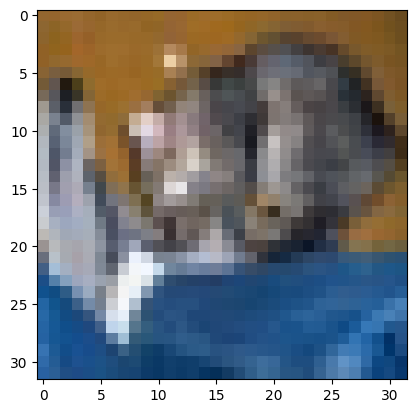

Model Name: AnalogWrapperResnet9
Per-layer Information
Layer Information                                                     | Tile Information              
Layer Name          Is Analog           In Shape            Out Shape           Kernel Shape        # of Tiles          Reuse Factor        Log. tile shape     Phys. tile shape    utilization (%)     
AnalogConv2d        analog              [1, 3, 32, 32]      [1, 28, 32, 32]     (3, 3)              1                   1024                -                   -                   -                   
                                                                                                                                            (28, 27)            N/A                 100.00              
BatchNorm2d         digital             [1, 28, 32, 32]     [1, 28, 32, 32]     -                   0                   0                   -                   -                   -                   
BatchNorm2d         digital           

In [5]:

# Create the model and load the weights
model = resnet9s().to(device)
download_url(
    "https://aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud/resnet9s.th",
    os.getcwd(),
)
state_dict = torch.load("resnet9s.th", device)
# The state dict of the model with hardware-aware trained weights is stored in the
# model_state_dict key of the external checkpoint.
model.load_state_dict(state_dict["model_state_dict"], strict=True)
rpu_config = CustomDefinedPreset()
model = convert_to_analog(model, CustomDefinedPreset())
model.eval()

# Load the test set
test_loader = get_test_loader()

# Plot specific dimension of a single instance in the test set and plot
# the sample
sample, _ = next(iter(test_loader))
sample = sample[0]
sample = sample.permute(1, 2, 0)
print(" Sample dimensions: ", sample.shape)
# Standardize the sample values in the range [0, 1]
sample = (sample - sample.min()) / (sample.max() - sample.min())
plt.imshow(sample)
plt.show()

# Get a summary of the analog model
analog_summary(model, (1, sample.shape[2], sample.shape[0], sample.shape[1]), rpu_config=CustomDefinedPreset())

# for analog_tile in model.analog_tiles():
#     print(analog_tile.get_weights())


### Toy Example
Since the model obtained from the analog conversion method is a non subscriptable object (AnalogWrapper), we will define a toy example, made up of a single layer, to demonstrate the quantization of the weights using the rpu_config parameters set above.

In [6]:

''' Taken form example '01_simple_layer.py' '''
def test():
    # Prepare the datasets (input and expected output).
    x = Tensor([[0.1, 0.2, 0.4, 0.3], [0.2, 0.1, 0.1, 0.3]])
    y = Tensor([[10.4, 30.5], [6.7, 40.3]])

    # Define a single-layer network, using a constant step device type.
    rpu_config = SingleRPUConfig(device=ConstantStepDevice())

    rpu_config.clip = WeightClipParameter(
        type=WeightClipType.FIXED_VALUE,
        fixed_value=0.5,
    )

    rpu_config.quantization = WeightQuantizerParameter(
        quantize = 0.5,
        bound = 1.0,
        rel_to_actual_bound=False,
    )


    model = AnalogLinear(4, 2, bias=True, rpu_config=rpu_config)

    analog_tile = next(model.analog_tiles())
    print("Info about the tile at initialization", analog_tile.get_weights())

    # Move the model and tensors to cuda if it is available.
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()
        model = model.cuda()

    # Define an analog-aware optimizer, preparing it for using the layers.
    opt = AnalogSGD(model.parameters(), lr=0.1)
    opt.regroup_param_groups(model)

    # Train the model.
    for epoch in range(100):
        # Delete old gradient
        opt.zero_grad()
        # Add the training Tensor to the model (input).
        pred = model(x)
        # Add the expected output Tensor.
        loss = mse_loss(pred, y)
        # Run training (backward propagation).
        loss.backward()

        opt.step()

        #print("Loss error: {:.16f}".format(loss))


    # Test the model
    print("\n\nEvaluation of the UNquantized model:")
    model.eval()
    with no_grad():
        pred = model(x)
        # print("Predicted: ", pred)
        # print("Expected: ", y)
        analog_tile = next(model.analog_tiles())
        print("Info about the tile", analog_tile.get_weights())


    # Generate a new model with weight discretization
    # rpu_config.modifier = WeightModifierParameter(
    #     std_dev=0.06,
    #     type=WeightModifierType.DISCRETIZE,
    #     res=0.5,
    #     enable_during_test=True,
    # )

    model_new = convert_to_analog(model, rpu_config, )

    # Import the model to the device
    #model_new.load_state_dict(model.state_dict(), load_rpu_config=True)


    # Test the new model
    print("\n\nEvaluation of the quantized model:")
    model_new.eval()
    with no_grad():
        pred = model_new(x)
        # print("Predicted: ", pred)
        # print("Expected: ", y)
        analog_tile = next(model_new.analog_tiles())
        print("Info about the tile", analog_tile.get_weights())


In [7]:

# Print the content of the analog tiles

test()


# t_inferences = [0.0, 3600.0, 86400.0]  # Times to perform infernece.
# n_reps = 5  # Number of inference repetitions.
# # Calibrate input ranges
# print("Performing input range calibration")
# calibrate_input_ranges(
#     model=model,
#     calibration_type=InputRangeCalibrationType.CACHE_QUANTILE,
#     dataloader=Sampler(test_loader, device),
# )
# # Determine the inference accuracy with the specified rpu configuration.
# print("Evaluating imported model.")
# inference_accuracy_values = torch.zeros((len(t_inferences), n_reps))
# for t_id, t in enumerate(t_inferences):
#     for i in range(n_reps):
#         model.drift_analog_weights(t)
#         inference_accuracy_values[t_id, i] = evaluate_model(
#             model, test_loader, device
#         )

#     print(
#         f"Test set accuracy (%) at t={t}s: mean: {inference_accuracy_values[t_id].mean()}, \
#             std: {inference_accuracy_values[t_id].std()}"
#     )

tensor([[ 0.0351,  0.0774,  0.4295, -0.4960],
        [ 0.2325,  0.2942, -0.1591,  0.2075]])

Info about the tile at initialization (tensor([[ 0.0207,  0.0196,  0.5048, -0.5040],
        [ 0.0030,  0.4925, -0.0022,  0.0101]]), tensor([0.2488, 0.1794]))


Evaluation of the UNquantized model:
Info about the tile (tensor([[-0.7911,  0.8538,  0.5352,  0.2929],
        [ 0.2338,  0.2225, -0.6653,  0.4189]]), tensor([ 8.3223, 35.3743]))

tensor([[-0.7911,  0.8538,  0.5352,  0.2929],
        [ 0.2338,  0.2225, -0.6653,  0.4189]])



Evaluation of the quantized model:
Info about the tile (tensor([[-0.7911,  0.8605,  0.5073,  0.5069],
        [ 0.0017,  0.0030, -0.5440,  0.4189]]), tensor([ 8.3223, 35.3743]))
